In [22]:
import os
import sys
import math
import numpy as np
import pandas as pd
import scipy.stats as stat
from itertools import groupby
from datetime import datetime
import matplotlib.pyplot as plt
R = 6.371*10**6

In [43]:
def cartesian(lat,lon):
  lat = lat/180*math.pi
  lon = lon/180*math.pi
  z = R*np.sin(lat)
  u = R*np.cos(lat)
  x = u*np.cos(lon)
  y = u*np.sin(lon)
  return x,y,z

def great_circle_dist(lat1,lon1,lat2,lon2):
  lat1 = lat1/180*math.pi
  lon1 = lon1/180*math.pi
  lat2 = lat2/180*math.pi
  lon2 = lon2/180*math.pi
  temp = np.cos(lat1)*np.cos(lat2)*np.cos(lon1-lon2)+np.sin(lat1)*np.sin(lat2)
  if isinstance(temp,np.ndarray):
    temp[temp>1]=1
    temp[temp<-1]=-1
  else:
    if temp>1:
      temp=1
    if temp<-1:
      temp=-1
  theta = np.arccos(temp)
  d = theta*R
  return d

def shortest_dist_to_great_circle(lat,lon,lat_start,lon_start,lat_end,lon_end):
  if abs(lat_start-lat_end)<1e-6 and abs(lon_start-lon_end)<1e-6:
    return np.zeros(len(lat))
  else:
    x,y,z = cartesian(lat,lon)
    x_start,y_start,z_start = cartesian(lat_start,lon_start)
    x_end,y_end,z_end = cartesian(lat_end,lon_end)
    cross_product = np.cross(np.array([x_start,y_start,z_start]),np.array([x_end,y_end,z_end]))
    N = cross_product/(np.linalg.norm(cross_product)+1e-6)
    C = np.array([x,y,z])/R
    temp = np.dot(N,C)
    if isinstance(temp,np.ndarray):
      temp[temp>1]=1
      temp[temp<-1]=-1
    else:
      if temp>1:
        temp=1
      if temp<-1:
        temp=-1
    NOC = np.arccos(temp)
    d = abs(math.pi/2-NOC)*R
    return d

def ExistKnot(mat,r,w):
  n = mat.shape[0]
  if n>1:
    lat_start = mat[0,2]
    lon_start = mat[0,3]
    lat_end = mat[n-1,2]
    lon_end = mat[n-1,3]
    lat = mat[:,2]
    lon = mat[:,3]                
    d = shortest_dist_to_great_circle(lat,lon,lat_start,lon_start,lat_end,lon_end)
    if max(d)<w:
      return 0, None
    else:
      return 1, np.argmax(d)
  else:
    return 0, None

In [2]:
MobMat = np.load("MobMat.npy")
MobMat

array([[1.0, 42.3671282595418, -71.11386696814662, ...,
        42.367119784506386, -71.11386987387306, 1551110114.256],
       [2.0, 42.367119784506386, -71.11386987387306, ...,
        42.367119784506386, -71.11386987387306, 1551110164.256],
       [1.0, 42.36698680561256, -71.1141078361041, ...,
        42.367130136156796, -71.11396282917923, 1551110994.256],
       ...,
       [2.0, 42.36714455303025, -71.11386694020698, ...,
        42.36714455303025, -71.11386694020698, 1552066144.256],
       [1.0, 42.36714455303025, -71.11386694020698, ...,
        42.36713368379731, -71.11392275949112, 1552066154.256],
       [2.0, 42.36713368379731, -71.11392275949112, ...,
        42.36713368379731, -71.11392275949112, 1552066214.256]],
      dtype=object)

In [3]:
MobMat.shape

(1133, 7)

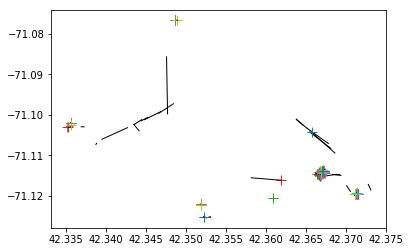

In [4]:
for i in range(np.shape(MobMat)[0]):
  if MobMat[i,0]==1:
    plt.plot([MobMat[i,1], MobMat[i,4]], [MobMat[i,2], MobMat[i,5]], 'k-', lw=1)
  if MobMat[i,0]==2:
    plt.plot(MobMat[i,1],MobMat[i,2],"+",ms=10)
plt.show()

In [5]:
sum(MobMat[:,0]==1)

532

## Define small functions in SOGP

In [36]:
## x = [t,g], where t is timestamp in seconds and g is x/y in meters
## period: 1 day = 24*60*60 = 86400s 1 week = 86400s*7 = 604800s

l1 = 30
l2 = 30
l3 = 0.001
a1 = 10
a2 = 10
g = 100
b1 = 0.2
b2 = 0.2
b3 = 0.6
sigma2=0.01
tol=0.05
d=100

## Locally Periodic Kernel： https://www.cs.toronto.edu/~duvenaud/cookbook/
def K0(x1,x2):
  k1 = np.exp(-abs(x1[0]-x2[0])/l1)*np.exp(-(np.sin(abs(x1[0]-x2[0])/86400*math.pi))**2/a1)
  k2 = np.exp(-abs(x1[0]-x2[0])/l2)*np.exp(-(np.sin(abs(x1[0]-x2[0])/604800*math.pi))**2/a2)
  k3 = np.exp(-abs(x1[1]-x2[1])/l3)
  return b1*k1+b2*k2+b3*k3

## similarity matrix between bv's
def update_K(bv,t,K,X):
  if t==0:
    mat = np.array([1])
  else:
    d = np.shape(K)[0]
    row = np.ones(d)
    column = np.ones([d+1,1])
    if X.ndim==1:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t,:],X[bv[i],:])
    mat = np.hstack([np.vstack([K,row]),column])
  return mat

## similarity vector between the t'th input with all bv's, t starts from 0 here
def update_k(bv,t,X):
  d = len(bv) 
  if d==0:
    out = np.array([0])
  if d>=1:
    out = np.zeros(d)
    if X.ndim==1:
      for i in range(d):
        out[i] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        out[i] = K0(X[t,:],X[bv[i],:])
  return out

def update_e_hat(Q,k):
  if np.shape(Q)[0]==0:
    out = np.array([0])
  else:
    out = np.dot(Q,k)
  return out

def update_gamma(k,e_hat):
  return 1-np.dot(k,e_hat)

def update_q(t,k,alpha,sigmax,Y):
  if t==0:
    out = Y[t]/sigmax
  else:
    out = (Y[t]-np.dot(k,alpha))/sigmax
  return out

def update_s_hat(C,k,e_hat):
  return np.dot(C,k)+e_hat

def update_eta(gamma,sigmax):
  r = -1/sigmax
  return 1/(1+gamma*r)

def update_alpha_hat(alpha,q,eta,s_hat):
  return alpha+q*eta*s_hat

def update_c_hat(C,sigmax,eta,s_hat):
  r = -1/sigmax
  return C+r*eta*np.outer(s_hat,s_hat)

def update_s(C,k):
  if np.shape(C)[0]==0:
    s = np.array([1])
  else:
    temp = np.dot(C,k)
    s = np.append(temp,1)
  return s

def update_alpha(alpha,q,s):
  T_alpha = np.append(alpha,0)
  new_alpha = T_alpha + q*s
  return new_alpha

def update_c(C,sigmax,s):
  d = np.shape(C)[0]
  if d==0:
    U_c = np.array([0])
  else:
    U_c = np.hstack([np.vstack([C,np.zeros(d)]),np.zeros([d+1,1])])
  r = -1/sigmax
  new_c = U_c+r*np.outer(s,s)
  return new_c

def update_Q(Q,gamma,e_hat):
  d = np.shape(Q)[0]
  if d==0:
    out = np.array([1])
  else:
    temp = np.append(e_hat,-1)
    new_Q = np.hstack([np.vstack([Q,np.zeros(d)]),np.zeros([d+1,1])])
    out = new_Q + 1/gamma*np.outer(temp,temp)
  return out
  
def update_alpha_vec(alpha,Q,C):
  t = len(alpha)-1
  return alpha[:t]-alpha[t]/(C[t,t]+Q[t,t])*(Q[t,:t]+C[t,:t])

def update_c_mat(C,Q):
  t = np.shape(C)[0]-1
  return C[:t,:t]+np.outer(Q[t,:t],Q[t,:t])/Q[t,t]-np.outer(Q[t,:t]+C[t,:t],Q[t,:t]+C[t,:t])/(Q[t,t]+C[t,t])

def update_q_mat(Q):
  t = np.shape(Q)[0]-1
  return Q[:t,:t]-np.outer(Q[t,:t],Q[t,:t])/Q[t,t]

def update_s_mat(k_mat,s_mat,index,Q):
  k_mat =  (k_mat[index,:])[:,index]
  s_mat =  (s_mat[index,:])[:,index]
  step1 = k_mat-k_mat.dot(s_mat).dot(k_mat)
  step2 = (step1[:d,:])[:,:d]
  step3 = Q - Q.dot(step2).dot(Q)
  return step3

## Define SOGP function

In [13]:
def SOGP(X,Y,sigma2,tol,d,Q=[],C=[],alpha=[],bv=[]):
  n = len(Y)
  I = 0 ## an indicator shows if it is the first time that the number of bvs hits d 
  for i in range(n):
    k = update_k(bv,i,X)
    if np.shape(C)[0]==0:
      sigmax = 1+sigma2
    else:
      sigmax = 1+sigma2+k.dot(C).dot(k)
    q = update_q(i,k,alpha,sigmax,Y)
    r = -1/sigmax
    e_hat = update_e_hat(Q,k)
    gamma = update_gamma(k,e_hat)
    if gamma<tol:
      s = update_s_hat(C,k,e_hat)
      eta = update_eta(gamma,sigmax)
      alpha = update_alpha_hat(alpha,q,eta,s)
      C = update_c_hat(C,sigmax,eta,s)
    else:
      s = update_s(C,k)
      alpha = update_alpha(alpha,q,s)
      C = update_c(C,sigmax,s)
      Q = update_Q(Q,gamma,e_hat)
      
      bv = np.array(np.append(bv,i),dtype=int)
      if len(bv)>=d:
        I = I + 1
      if I==1:
        K = np.zeros([d,d])
        if X.ndim==1:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i]],X[bv[j]])
        else:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i],:],X[bv[j],:])
        S = np.linalg.inv(np.linalg.inv(C)+K)
        
      if len(bv)>d:
        alpha_vec = update_alpha_vec(alpha,Q,C)
        c_mat = update_c_mat(C,Q)
        q_mat = update_q_mat(Q)
        s_mat = np.hstack([np.vstack([S,np.zeros(d)]),np.zeros([d+1,1])])
        s_mat[d,d] = 1/sigma2
        k_mat = update_K(bv,i,K,X)
        eps = np.zeros(d)
        for j in range(d):
          eps[j] = alpha_vec[j]/(q_mat[j,j]+c_mat[j,j])-s_mat[j,j]/q_mat[j,j]+np.log(1+c_mat[j,j]/q_mat[j,j])
        loc = np.where(eps == np.min(eps))[0]
        bv = np.array(np.delete(bv,loc),dtype=int)
        if loc==0:
          index = np.append(np.arange(1,d+1),0)
        else:
          index = np.append(np.append(np.arange(0,loc),np.arange(loc+1,d+1)),loc)
        alpha = update_alpha_vec(alpha[index],(Q[index,:])[:,index],(C[index,:])[:,index])
        
        C = update_c_mat((C[index,:])[:,index],(Q[index,:])[:,index])
        Q = update_q_mat((Q[index,:])[:,index])
        S = update_s_mat(k_mat,s_mat,index,Q)
        K = (k_mat[index[:d],:])[:,index[:d]]
  output = {'bv':bv,'alpha':alpha,'Q':Q,'C':C}
  return output

## Put everything together to obtain BV set

In [14]:
def BV_select(MobMat,sigma2,tol,d):
  mean_x = (MobMat[:,1]+MobMat[:,4])/2
  mean_y = (MobMat[:,2]+MobMat[:,5])/2
  mean_t = (MobMat[:,3]+MobMat[:,6])/2
  X = np.transpose(np.vstack((mean_t,mean_x)))
  Y = mean_y
  result1 = SOGP(X,Y,sigma2,tol,d)['bv']
  X = np.transpose(np.vstack((mean_t,mean_y)))
  Y = mean_x
  result2 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = np.unique(np.append(result1,result2))
  BV_set = MobMat[index,:]
  return {'BV_set':BV_set,'BV_index':index}

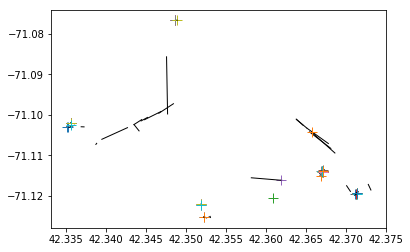

In [15]:
BV_set = BV_select(MobMat,sigma2,tol,d)["BV_set"]
for i in range(np.shape(BV_set)[0]):
  if BV_set[i,0]==1:
    plt.plot([BV_set[i,1],BV_set[i,4]], [BV_set[i,2], BV_set[i,5]], 'k-', lw=1)
  if BV_set[i,0]==2:
    plt.plot(BV_set[i,1],BV_set[i,2],"+",ms=10)
plt.show()

In [16]:
BV_set.shape

(169, 7)

## Impute the missing trajectories using BV

In [45]:
def create_tables(MobMat, BV_set):
  n = np.shape(MobMat)[0]
  m = np.shape(BV_set)[0]
  index = [BV_set[i,0]==1 for i in range(m)]
  flight_table = BV_set[index,:]
  index = [BV_set[i,0]==2 for i in range(m)]
  pause_table = BV_set[index,:]
  mis_table = np.zeros(8)
  for i in range(n-1):
    if MobMat[i+1,3]!=MobMat[i,6]:
      ## also record if it's flight/pause before and after the missing interval
      mov = np.array([MobMat[i,4],MobMat[i,5],MobMat[i,6],MobMat[i+1,1],MobMat[i+1,2],MobMat[i+1,3],MobMat[i,0],MobMat[i+1,0]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)
  return flight_table, pause_table, mis_table

In [46]:
def K1(method,current_t,current_x,current_y,BV_set):
  mean_x = ((BV_set[:,1] + BV_set[:,4])/2).astype(float)
  mean_y = ((BV_set[:,2] + BV_set[:,5])/2).astype(float)
  mean_t = ((BV_set[:,3] + BV_set[:,6])/2).astype(float)
  if method=="TL":
    k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
    k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)
    return b1/(b1+b2)*k1+b2/(b1+b2)*k2
  if method=="GL":
    d = great_circle_dist(current_x,current_y,mean_x,mean_y)
    return np.exp(-d/g)
  if method=="GLC":
    k1 = np.exp(-abs(current_t-mean_t)/l1)*np.exp(-(np.sin(abs(current_t-mean_t)/86400*math.pi))**2/a1)
    k2 = np.exp(-abs(current_t-mean_t)/l2)*np.exp(-(np.sin(abs(current_t-mean_t)/604800*math.pi))**2/a2)
    d = great_circle_dist(current_x,current_y,mean_x,mean_y)
    k3 = np.exp(-d/g)
    return b1*k1+b2*k2+b3*k3

In [51]:
def I_flight(method,current_t,current_x,current_y,dest_t,dest_x,dest_y,BV_set,z):
  K = K1(method,current_t,current_x,current_y,BV_set)
  flight_K = K[BV_set[:,0]==1]
  pause_K = K[BV_set[:,0]==2]
  sorted_flight = np.sort(flight_K)[::-1]
  sorted_pause = np.sort(pause_K)[::-1]
  p0 = np.mean(sorted_flight[0:num])/(np.mean(sorted_flight[0:num])+np.mean(sorted_pause[0:num]))
  d_dest = great_circle_dist(current_x,current_y,dest_x,dest_y)
  v_dest = d_dest/(dest_t-current_t+0.0001)
  ## design an exponential function here to adjust the probability based on the speed needed
  ## p = p0*exp(|v-2|+/s)  v=2--p=p0   v=14--p=1
  if p0 < 1e-5:
    p0 = 1e-5
  if p0 > 1-1e-5:
    p0 = 1-1e-5
  s = -12/np.log(p0)
  p1 = min(1,p0*np.exp(min(max(0,v_dest-2)/s,1e2)))
  out = stat.bernoulli.rvs(p1,size=z)
  return out

def adjust_direction(delta_x,delta_y,start_x,start_y,end_x,end_y):
  direction = np.array([end_x-start_x,end_y-start_y])
  inner_product = np.inner(direction,np.array([delta_x,delta_y]))
  if inner_product>=0:
    return delta_x,delta_y
  else:
    return -delta_x,-delta_y
  
def multiplier(t_diff):
  if t_diff<=10*60:
    return 1
  elif t_diff<=60*60:
    return 5
  elif t_diff<=720*60:
    return 10
  else:
    return 50

In [48]:
def ImputeGPS(MobMat,BV_set,method,switch):
  sys.stdout.write("Imputing missing trajectories..." + '\n')
  flight_table, pause_table, mis_table = create_tables(MobMat, BV_set)
  imp_x0 = np.array([]); imp_x1 = np.array([])
  imp_y0 = np.array([]); imp_y1 = np.array([])
  imp_t0 = np.array([]); imp_t1 = np.array([])
  imp_s = np.array([])

  for i in range(mis_table.shape[0]):
     ## if a person remains at the same place at the begining and end of missing, just assume he satys there all the time
    if mis_table[i,0]==mis_table[i,3] and mis_table[i,1]==mis_table[i,4]:
      imp_s = np.append(imp_s,2)
      imp_x0 = np.append(imp_x0, mis_table[i,0])
      imp_x1 = np.append(imp_x1, mis_table[i,3])
      imp_y0 = np.append(imp_y0, mis_table[i,1])
      imp_y1 = np.append(imp_y1, mis_table[i,4])
      imp_t0 = np.append(imp_t0, mis_table[i,2])
      imp_t1 = np.append(imp_t1, mis_table[i,5])
    else:
      ## solve the problem that a person has a trajectory like flight/pause/flight/pause/flight...
      ## we want it more like flght/flight/flight/pause/pause/pause/flight/flight...
      ## start from two ends, we make it harder to change the current pause/flight status by drawing multiple random
      ## variables form bin(p0) and require them to be all 0/1
      ## "switch" is the number of random variables
      start_t = mis_table[i,2]; end_t = mis_table[i,5]
      start_x = mis_table[i,0]; end_x = mis_table[i,3]
      start_y = mis_table[i,1]; end_y = mis_table[i,4]
      start_s = mis_table[i,6]; end_s = mis_table[i,7]

      while start_t < end_t:
        I0 = I_flight(method,start_t,start_x,start_y,end_t,end_x,end_y,BV_set,switch)
        if (sum(I0==1)==switch and start_s==2) or (sum(I0==0)<switch and start_s==1):
          weight = K1(method,start_t,start_x,start_y,flight_table)
          normalize_w = (weight+1e-5)/sum(weight+1e-5)
          flight_index = np.random.choice(flight_table.shape[0], p=normalize_w)
          delta_x = (flight_table[flight_index,4]-flight_table[flight_index,1])*multiplier(end_t-start_t)
          delta_y = (flight_table[flight_index,5]-flight_table[flight_index,2])*multiplier(end_t-start_t)
          delta_t = (flight_table[flight_index,6]-flight_table[flight_index,3])*multiplier(end_t-start_t)
          if(start_t + delta_t > end_t):
            temp = delta_t
            delta_t = end_t-start_t
            delta_x = delta_x*delta_t/temp
            delta_y = delta_y*delta_t/temp
          delta_x,delta_y = adjust_direction(delta_x,delta_y,start_x,start_y,end_x,end_y)
          if end_t>start_t:
            imp_s = np.append(imp_s,1)
            imp_t0 = np.append(imp_t0,start_t)
            current_t = start_t + delta_t
            imp_t1 = np.append(imp_t1,current_t)
            imp_x0 = np.append(imp_x0,start_x)
            current_x = (end_t-current_t)/(end_t-start_t)*(start_x+delta_x)+(current_t-start_t)/(end_t-start_t)*end_x
            imp_x1 = np.append(imp_x1,current_x)
            imp_y0 = np.append(imp_y0,start_y)
            current_y = (end_t-current_t)/(end_t-start_t)*(start_y+delta_y)+(current_t-start_t)/(end_t-start_t)*end_y
            imp_y1 = np.append(imp_y1,current_y)
            start_x = current_x; start_y = current_y; start_t = current_t
        else:
          weight = K1(method,start_t,start_x,start_y,pause_table)
          normalize_w = (weight+1e-5)/sum(weight+1e-5)
          pause_index = np.random.choice(pause_table.shape[0], p=normalize_w)
          delta_t = (pause_table[pause_index,6]-pause_table[pause_index,3])*multiplier(end_t-start_t)
          if(start_t+delta_t>end_t):
            delta_t = end_t-start_t
          if end_t>start_t:
            imp_s = np.append(imp_s,2)
            imp_t0 = np.append(imp_t0,start_t)
            current_t = start_t + delta_t
            imp_t1 = np.append(imp_t1,current_t)
            imp_x0 = np.append(imp_x0,start_x)
            imp_x1 = np.append(imp_x1,start_x)
            imp_y0 = np.append(imp_y0,start_y)
            imp_y1 = np.append(imp_y1,start_y)
            start_t = current_t

        I1 = I_flight(method,end_t,end_x,end_y,start_t,start_x,start_y,BV_set,switch)
        if (sum(I1==1)==switch and end_s==2) or (sum(I1==0)<switch and end_s==1):
          weight = K1(method,end_t,end_x,end_y,flight_table)
          normalize_w = (weight+1e-5)/sum(weight+1e-5)
          flight_index = np.random.choice(flight_table.shape[0], p=normalize_w)
          delta_x = (flight_table[flight_index,4]-flight_table[flight_index,1])*multiplier(end_t-start_t)
          delta_y = (flight_table[flight_index,5]-flight_table[flight_index,2])*multiplier(end_t-start_t)
          delta_t = (flight_table[flight_index,6]-flight_table[flight_index,3])*multiplier(end_t-start_t)
          if(start_t + delta_t > end_t):
            temp = delta_t
            delta_t = end_t-start_t
            delta_x = delta_x*delta_t/temp
            delta_y = delta_y*delta_t/temp
          delta_x,delta_y = adjust_direction(delta_x,delta_y,end_x,end_y,start_x,start_y)
          if end_t>start_t:
            imp_s = np.append(imp_s,1)
            imp_t1 = np.append(imp_t1,end_t)
            current_t = end_t - delta_t
            imp_t0 = np.append(imp_t0,current_t)
            imp_x1 = np.append(imp_x1,end_x)
            current_x = (end_t-current_t)/(end_t-start_t)*start_x+(current_t-start_t)/(end_t-start_t)*(end_x+delta_x)
            imp_x0 = np.append(imp_x0,current_x)
            imp_y1 = np.append(imp_y1,end_y)
            current_y = (end_t-current_t)/(end_t-start_t)*start_y+(current_t-start_t)/(end_t-start_t)*(end_y+delta_y)
            imp_y0 = np.append(imp_y0,current_y)
            end_x = current_x; end_y = current_y; end_t = current_t
        else:
          weight = K1(method,end_t,end_x,end_y,pause_table)
          normalize_w = (weight+1e-5)/sum(weight+1e-5)
          pause_index = np.random.choice(pause_table.shape[0], p=normalize_w)
          delta_t = (pause_table[pause_index,6]-pause_table[pause_index,3])*multiplier(end_t-start_t)
          if(start_t+delta_t>end_t):
            delta_t = end_t-start_t
          if end_t>start_t:
            imp_s = np.append(imp_s,2)
            imp_t1 = np.append(imp_t1,end_t)
            current_t = end_t - delta_t
            imp_t0 = np.append(imp_t0,current_t)
            imp_x0 = np.append(imp_x0,end_x)
            imp_x1 = np.append(imp_x1,end_x)
            imp_y0 = np.append(imp_y0,end_y)
            imp_y1 = np.append(imp_y1,end_y)
            end_t = current_t
  imp_table=np.stack([imp_s,imp_x0,imp_y0,imp_t0,imp_x1,imp_y1,imp_t1], axis=1)
  imp_table = imp_table[imp_table[:,3].argsort()].astype(float)
  return imp_table

In [49]:
def Imp2traj(imp_table,MobMat,itrvl=10,r=None,w=None,h=None):
  sys.stdout.write("Tidying up the trajectories..." + '\n')
  if r is None:
    r = np.sqrt(itrvl)
  if h is None:
    h = r
  if w is None:
    w = 3*r
  mis_table = np.zeros(8)
  for i in range(np.shape(MobMat)[0]-1):
    if MobMat[i+1,3]!=MobMat[i,6]:
      ## also record if it's flight/pause before and after the missing interval
      mov = np.array([MobMat[i,4],MobMat[i,5],MobMat[i,6],MobMat[i+1,1],MobMat[i+1,2],MobMat[i+1,3],MobMat[i,0],MobMat[i+1,0]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)

  traj = []
  for k in range(mis_table.shape[0]):
    index = (imp_table[:,3]>=mis_table[k,2])*(imp_table[:,6]<=mis_table[k,5])
    temp = imp_table[index,:]
    a = 0
    b = 1
    while a < temp.shape[0]:
      if b < temp.shape[0]:
        if temp[b,0] == temp[a,0]:
          b = b + 1
      if b==temp.shape[0] or temp[min(b,temp.shape[0]-1),0]!=temp[a,0]:
        start = a
        end = b-1
        a = b
        b = b+1
        if temp[start,0]==2:
          traj.append([2,temp[start,1],temp[start,2],temp[start,3],temp[end,4],temp[end,5],temp[end,6]])
        elif end == start:
          traj.append([1,temp[start,1],temp[start,2],temp[start,3],temp[end,4],temp[end,5],temp[end,6]])
        else:
          mat = np.vstack((temp[start,1:4],temp[np.arange(start,end+1),4:7]))
          mat = np.append(mat,np.arange(0,mat.shape[0]).reshape(mat.shape[0],1),1)
          complete = 0
          knots = [0,mat.shape[0]-1]
          while complete == 0:
            mat_list = []
            for i in range(len(knots)-1):
              mat_list.append(mat[knots[i]:min(knots[i+1]+1,mat.shape[0]-1),:])
            knot_yes = np.empty(len(mat_list))
            knot_pos = np.empty(len(mat_list))
            for i in range(len(mat_list)):
              knot_yes[i] , knot_pos[i] = ExistKnot(mat_list[i],r,w)
            if sum(knot_yes)==0:
              complete = 1
            else:
              for i in range(len(mat_list)):
                if knot_yes[i]==1:
                  knots.append(int((mat_list[i])[int(knot_pos[i]),3]))
              knots.sort()
          out = []
          for j in range(len(knots)-1):
            traj.append([1,mat[knots[j],0],mat[knots[j],1],mat[knots[j],2],mat[knots[j+1],0],mat[knots[j+1],1],mat[knots[j+1],2]])
  traj = np.array(traj)
  traj = np.hstack((traj,np.zeros((traj.shape[0],1))))
  MobMat = np.hstack((MobMat,np.ones((MobMat.shape[0],1))))
  full_traj = np.vstack((traj,MobMat))
  return(full_traj[full_traj[:,3].argsort()].astype(float))

In [52]:
imp_table= ImputeGPS(MobMat,BV_set,"GLC",4)
imp_table.shape

Imputing missing trajectories...


(9290, 7)

In [53]:
traj = Imp2traj(imp_table,MobMat)
traj.shape

Tidying up the trajectories...


(5844, 8)

In [57]:
sp=great_circle_dist(traj[:,1],traj[:,2],traj[:,4],traj[:,5])/(traj[:,6]-traj[:,3])
sp0=sp[sp>0]
np.mean(sp0)

0.6876987352978509

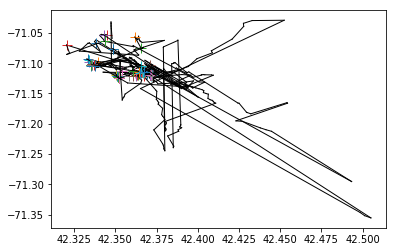

In [58]:
for i in range(np.shape(traj)[0]):
  if traj[i,0]==1:
    plt.plot([traj[i,1],traj[i,4]], [traj[i,2], traj[i,5]], 'k-', lw=1)
  if traj[i,0]==2:
    plt.plot(traj[i,1],traj[i,2],"+",ms=10)
plt.show()

In [60]:
np.save("FullMobMat",traj)
traj = pd.DataFrame(traj)
traj.columns = ["status","x0","y0","t0","x1","y1","t1","obs"]
traj.to_csv("MobMat.csv")